# Machine Learning : Model Fit

# Load the packages

In [261]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib

# gradient boosting for regression in scikit-learn
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_classification
#from sklearn.experimental import enable_hist_gradient_boosting

In [262]:
from lightgbm import LGBMClassifier

# Read the train data set 

In [263]:
import pickle
 
X, y = pickle.load( open( "cluster-mldata.plk", "rb" ) )

In [264]:
X.shape

(4442, 2)

In [265]:
y

array([1, 1, 0, ..., 0, 0, 0])

In [266]:
y.shape

(4442,)

# Model: LightGBMClassifier
# Simple Fit using the whole train sample

In [267]:
# Fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X, y)
y_pred = model.predict(X)

In [268]:
X[:3]

array([[1.25535063, 0.50260564],
       [0.90156951, 0.01291567],
       [1.16625186, 0.47100378]])

In [269]:
print(y_pred)

[1 1 0 ... 1 0 0]


In [270]:
# Make a single prediction
# row = [[0.90156951, 0.01291567]]
row = X
yhat = model.predict(row)

In [271]:
yhat

array([1, 1, 0, ..., 1, 0, 0])

In [272]:
yhat.shape

(4442,)

In [273]:
yhat[0]

1

In [274]:
print('Prediction: %f' % yhat[0])

Prediction: 1.000000


In [275]:
y[:3]

array([1, 1, 0])

In [276]:
len(y), y.sum()

(4442, 2676)

In [277]:
y.shape

(4442,)

In [278]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.8041422782530392

Text(24.0, 0.5, 'HasDetections')

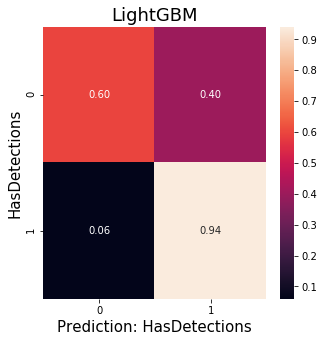

In [280]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y, y_pred,)
conf_mx

cm = confusion_matrix(y, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))

hm = sn.heatmap(cmn, annot=True, fmt='.2f')#, x_label='label')
hm.axes.set_title("LightGBM",fontsize=18)
hm.set_xlabel('Prediction: HasDetections',fontsize=15)
hm.set_ylabel('HasDetections',fontsize=15)

# Trying Various Hyper-parameters : Grid Search

In [281]:
from sklearn.model_selection import GridSearchCV

In [282]:
# Set params
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'n_estimators' : 100,
          'num_leaves': 31,
          'learning_rate': 0.5,
          'objective': 'binary',
          'nthread': 1,       
          'max_bin': 512,
          'subsample_for_bin': 5000,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
#          'num_class' : 1,
          'metric' : 'binary_error'
         }

In [283]:
# Model setting
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 1,
          silent = True,
          max_depth = params['max_depth'],
          n_estimators = params['n_estimators'],
          learning_rate = params['learning_rate'],
          num_leaves = params['num_leaves'])
                     
# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [284]:
# Create grid parameters to search
gridParams = {
    'learning_rate': [0.5,1.0],
    'num_leaves': [15,30],
    'n_estimators': [100,200,300],
}   

In [285]:
# Create the grid
allmodels = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=5,
                    n_jobs=1)

In [286]:
%%time
# Run the grid

allmodels.fit(X, y)

CPU times: user 5.16 s, sys: 33.4 ms, total: 5.19 s
Wall time: 5.23 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.5, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.5, 1.0],
  

In [287]:
print(allmodels.best_params_)

{'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 15}


In [288]:
print(allmodels.best_score_)

0.6949578937767915


In [289]:
X[:3]

array([[1.25535063, 0.50260564],
       [0.90156951, 0.01291567],
       [1.16625186, 0.47100378]])

In [290]:
fmodel = allmodels.best_estimator_

In [291]:
fmodel.predict_proba([[0.90156951, 0.01291567]])

array([[0.08241282, 0.91758718]])

In [292]:
fmodel.predict([[0.90156951, 0.01291567]])[0]

1

# Prediction using the best model

In [293]:
y_pred = fmodel.predict(X)

In [294]:
y_pred.shape

(4442,)

In [295]:
y_pred[:6]

array([1, 1, 0, 1, 1, 1])

In [296]:
y[:6]

array([1, 1, 0, 1, 1, 1])

In [297]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.8408374606033319

# Confusion matrix

In [298]:
# make cm
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y, y_pred)
conf_mx

array([[1226,  540],
       [ 167, 2509]])

In [299]:
pd.crosstab(y, y_pred)

col_0,0,1
row_0,,
0,1226,540
1,167,2509


Text(24.0, 0.5, 'HasDetections')

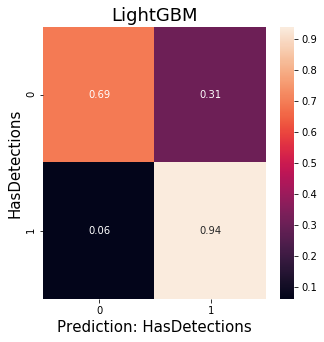

In [300]:
# plot cm
import seaborn as sn

cm = confusion_matrix(y, y_pred)
# normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5,5))
hm = sn.heatmap(cmn, annot=True, fmt='.2f')#, x_label='label')
hm.axes.set_title("LightGBM",fontsize=18)
hm.set_xlabel('Prediction: HasDetections',fontsize=15)
hm.set_ylabel('HasDetections',fontsize=15)